In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

# 1. Basic EDA

In [2]:
df = pd.read_excel('~/Desktop/USF_courses/Practicum/data/BrainMets_List_July2020_LF_OS.xlsx')

#### Get patient number
def get_patient(col):
    lst = col.split('-')
    return lst[2]

#### Response_v: use time to death if it is not null else positive follow-up time
def get_response(df):
    if df['Time to death']>0:
        return df['Time to death']
    elif df['Follow-up time']>0:
        return df['Follow-up time']
    
df['patient'] = df['PiCare MetID'].apply(lambda x:get_patient(x))
df['response_v'] = df.apply(lambda x:get_response(x),axis=1)

In [3]:
def drop_column(data, col):
    return data.drop(columns=[col])

In [4]:
df.shape

(10445, 58)

In [5]:
#Drop columns that are all null value
for col in df.columns:
    if df[col].isnull().sum()==10445:
        df = drop_column(df,col)
df.shape

(10445, 43)

In [6]:
df['Primary tumor Site'].value_counts()

Lung        3716
Breast      3030
Melanoma    2194
Kidney       521
GI           306
Other        241
GYN          194
Sarcoma      125
Unknown      102
Name: Primary tumor Site, dtype: int64

In [7]:
df['Primary tumor Histology'].value_counts()

Met_AdenoCA                    6285
Met_Melanoma                   2197
Met_Renal_cell_CA               421
Met_Carcinoma_NOS               396
Met_Other                       185
Met_Small_cell_CA               178
Met_Squamous_cell_CA            168
Met_Small_Cell_CA               119
Met_Sarcoma                     117
Met_Renal_Cell_CA                90
Met_Large_cell_CA                80
Met_Squamous_Cell_CA             63
Met_Adenosquamous_CA             50
Met_Bronchoalveolar_CA           30
Met_Large_Cell_CA                20
Met_Germ_cell_tumor              12
Bone_met                         10
Met_Germ_Cell_Tumor               3
Met_                              2
Met_Squamous call carcinoma       2
Met_Lymphoma                      1
Name: Primary tumor Histology, dtype: int64

In [8]:
df['KPS at 1st GK'].unique()

array([ 80.,  60.,  90.,  70.,  50., 100.,  40.,  nan])

In [9]:
df['ECM'].value_counts()

True     7588
False    1975
0         810
Unkn       72
Name: ECM, dtype: int64

In [10]:
df['#Metastases at 1st GK'].unique()

array([ 3.,  5.,  4.,  2.,  6.,  1.,  9.,  8., 10.,  7., 22., 16., 14.,
       17., 12., 11., 31., 13., 15., 19., 18., 24., 61., 20., 27., 25.,
       29., nan, 26., 30., 23.])

In [11]:
#### Convert all 1/0 to True/False
def binary(col):
    if col == '1' or col == 1:
        return 'True'
    if col == '0' or col == 0:
        return 'False'
    return col
df['ECM'] = df['ECM'].apply(lambda x:binary(x))
df['ECM'].unique()

array(['False', 'True', 'Unkn'], dtype=object)

# Compute GPA Score

In [12]:
def lung_gpa(dff):
    gpa = 0
    if dff[['Age','KPS at 1st GK','ECM','#Metastases at 1st GK']].isnull().any().any() == True:
        return np.nan
    #Age
    if (dff['Age'] >= 50) & (dff['Age']<=60):
        gpa += 0.5
    if dff['Age']<50:
        gpa +=1
    #KPS
    if (dff['KPS at 1st GK']>= 70)& (dff['KPS at 1st GK']<=80):
        gpa+=0.5
    if (dff['KPS at 1st GK']>= 90)& (dff['KPS at 1st GK']<=100):
        gpa +=1
    #ECM
    if dff['ECM']=='False':
        gpa += 1
    # No.of BM
    if (dff['#Metastases at 1st GK']>=2) & (dff['#Metastases at 1st GK']<=3):
        gpa +=0.5
    if dff['#Metastases at 1st GK']==1:
        gpa+=1
    return gpa

def melanoma_gpa(dff):
    gpa = 0
    if dff[['KPS at 1st GK','#Metastases at 1st GK']].isnull().any().any() == True:
        return np.nan
    
    #KPS
    if (dff['KPS at 1st GK']>= 70)& (dff['KPS at 1st GK']<=80):
        gpa +=1
    if (dff['KPS at 1st GK']>= 90)& (dff['KPS at 1st GK']<=100):
        gpa +=1
        
    # No.of BM
    if (dff['#Metastases at 1st GK']>=2) & (dff['#Metastases at 1st GK']<=3):
        gpa +=1
    if dff['#Metastases at 1st GK']==1:
        gpa +=2
    return gpa

#Renal cell carcinoma
def kidney_gpa(dff):
    gpa = 0
    if dff[['KPS at 1st GK','#Metastases at 1st GK']].isnull().any().any() == True:
        return np.nan    
    #KPS
    if (dff['KPS at 1st GK']>= 70)& (dff['KPS at 1st GK']<=80):
        gpa +=1
    if (dff['KPS at 1st GK']>= 90)& (dff['KPS at 1st GK']<=100):
        gpa +=1
        
    # No.of BM
    if (dff['#Metastases at 1st GK']>=2) & (dff['#Metastases at 1st GK']<=3):
        gpa +=1
    if dff['#Metastases at 1st GK']==1:
        gpa +=2
    return gpa

def gi_gpa(dff):
    if dff[['KPS at 1st GK']].isnull().any().any() == True:
        return np.nan    
    #KPS
    if dff['KPS at 1st GK']== 70:
        return 1
    if dff['KPS at 1st GK']==80:
        return 2
    if dff['KPS at 1st GK']==90:
        return 3
    if dff['KPS at 1st GK']==100:
        return 4
    


def add_gpa(df):
    if df['Primary tumor Site']=='GI': return gi_gpa(df)
    if df['Primary tumor Site']=='Kidney': return kidney_gpa(df)
    if df['Primary tumor Site']=='Lung': return lung_gpa(df)
    if df['Primary tumor Site']=='Melanoma': return gi_gpa(df)
    if df['Primary tumor Site']=='Breast': return lung_gpa(df) ## Same criteria as lung


def gpa_range(gpa):
    if gpa >=0 and gpa<=1:
        return '0-1'
    if gpa >=1.5 and gpa<=2:
        return '1.5-2'
    if gpa >=2.5 and gpa<=3:
        return '2.5-3'
    if gpa >=3.5 and gpa<=4:
        return '3.5-4'


In [13]:
df['GPA'] = df.apply(lambda x:add_gpa(x),axis =1)
df['GPA_range'] = df['GPA'].apply(lambda x:gpa_range(x))

In [14]:
#### Drop data without GPA/response_v
df_patients = df[['patient','Primary tumor Site','Age','KPS at 1st GK','ECM','#Metastases at 1st GK','response_v','GPA','GPA_range','Time to death','Follow-up time','Date GK']].drop_duplicates().dropna(subset=['GPA','response_v'])

In [15]:
#### Only keep first GK data for one patient
df_patients_keepfirst = df_patients.sort_values(by = 'Date GK').drop_duplicates(subset = ['patient'],keep = 'first')

In [16]:
df_patients_keepfirst.shape

(1381, 12)

# Kaplan_Meier Estimation

In [17]:
df_patients_keepfirst['alive'] = df_patients_keepfirst['Time to death'].apply(lambda x: 0 if pd.isnull(x) == True else 1)

df_curve = df_patients_keepfirst[['alive','response_v','GPA_range','Primary tumor Site']].dropna()

df_curve['alive'] = df_curve['alive'].apply(lambda x: x == 1)

In [18]:
df_curve['alive'].value_counts()

True     1267
False     114
Name: alive, dtype: int64

In [20]:
gpa_range = ['0-1', '1.5-2', '2.5-3', '3.5-4']

In [21]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

kmf = KaplanMeierFitter(label='Overall')
kmf.fit(df_curve['response_v'],df_curve['alive'])

<lifelines.KaplanMeierFitter:"Overall", fitted with 1381 total observations, 114 right-censored observations>

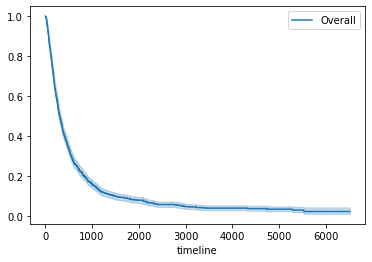

In [22]:
kmf.plot()
plt.show()

In [23]:
def survival_curve_kmf(data,cluster_list,site_name, classes = "GPA_range", survival_col = "alive",time_col = "response_v"):
    ax = plt.subplot(111)
    ci_lst = [] #(site_name, gpa_range, median, lower_ci, higher_ci)
    for c in cluster_list:
        mask = data[classes] == c
        if len(data[survival_col][mask]) ==0:
            continue
        kmf.fit(data[time_col][mask],event_observed=data[survival_col][mask],label = f"GPA_range = {c}")
        median = kmf.median_survival_time_
        l,r = median_survival_times(kmf.confidence_interval_).iloc[0]
        ci_lst.append((site_name, c, median, l, r))
        kmf.plot_survival_function(ax=ax)


    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('Survival Curve for %s' % site_name)
    plt.show()
    return ci_lst

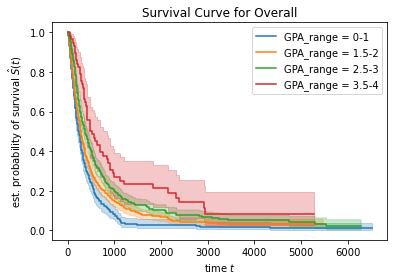

In [24]:
ci= survival_curve_kmf(df_curve,gpa_range,'Overall')

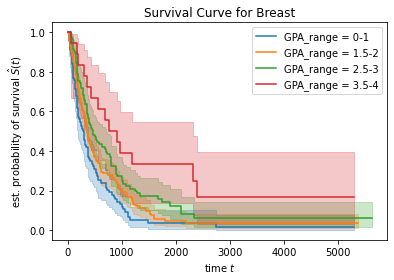

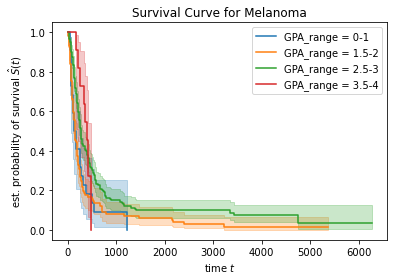

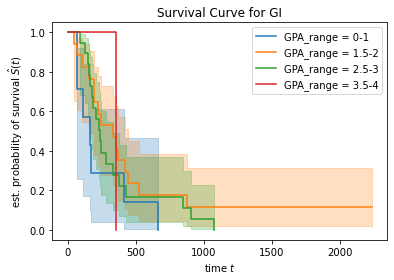

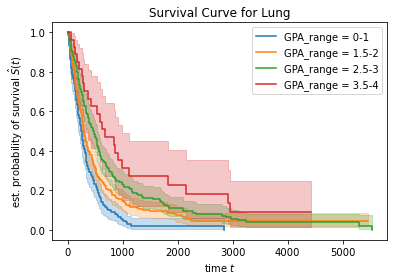

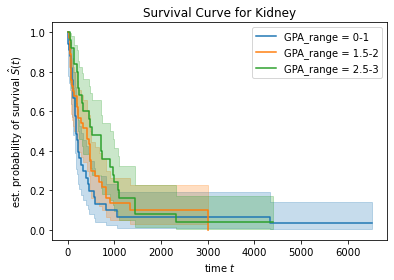

In [25]:
for site in df_curve['Primary tumor Site'].unique():
    dff = df_curve[df_curve['Primary tumor Site']==site]
    ci_site = survival_curve_kmf(dff,gpa_range,site)
    ci.extend(ci_site)

In [26]:
result = pd.DataFrame(ci,columns=[['Primary_site','GPA_range','KMF_median','Lower_median_CI','Higher_median_CI']])

In [27]:
result

,Primary_site,GPA_range,KMF_median,Lower_median_CI,Higher_median_CI
0,Overall,0-1,240.0,193.0,275.0
1,Overall,1.5-2,281.0,255.0,312.0
2,Overall,2.5-3,375.0,325.0,430.0
3,Overall,3.5-4,530.0,400.0,851.0
4,Breast,0-1,294.0,186.0,373.0
5,Breast,1.5-2,366.0,311.0,428.0
6,Breast,2.5-3,461.0,356.0,712.0
7,Breast,3.5-4,906.0,352.0,2320.0
8,Melanoma,0-1,127.0,77.0,281.0
9,Melanoma,1.5-2,143.0,119.0,194.0


#### Documents
* https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html
* https://github.com/CamDavidsonPilon/lifelines/blob/master/docs/Survival%20analysis%20with%20lifelines.rst